In [1]:
import numpy as np
import librosa
import librosa.display
import librosa.feature
import pickle
import glob
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
def solo_path_gen(audio_folder):
    audio_paths = glob.glob(audio_folder + '*')
    solo_paths = np.array([])
    for audio in audio_paths:
        temp = audio.split('/')[-1].split('_')[-2]
        if temp == 'solo':
            solo_paths = np.append(solo_paths, audio)
    return solo_paths

In [3]:
def save_pkl(data, output_filename):   
    output = open(output_filename, 'wb')
    pickle.dump(data, output)
    output.close()
    
def file_size_estimate(X):
    ref_dimension = float(2130 * 1025 * 101)
    ref_size_GB = 882.9/1024
    return (X.shape[0] * X.shape[1] * X.shape[2]/(ref_dimension) * ref_size_GB) + 1

def save_pkl_chunks(data, output_path, chunks):
    for i in np.arange(chunks):
        segment = data[i * data.shape[0]//chunks: (i+1) * data.shape[0]//chunks]
        save_pkl(segment, output_path + 'chunk{}'.format(i))
    
def read_pkl(filename):
    pkl_file = open(filename, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data
    
def read_pkl_chunks(folder_path):
#     all_data = np.array([])
    pkl_files = glob.glob(folder_path + '*')
    pkl_files.remove(folder_path + 'labels')
    for chunk in np.arange(len(pkl_files)):
        if chunk == 0:
            data0 = read_pkl(pkl_files[chunk])
            all_data = data0 
            print (all_data.shape)
        if chunk == 1:
            data1 = read_pkl(pkl_files[chunk])
            #all_data = np.vstack([data0, data1])
            all_data = np.concatenate((data0, data1),axis=0)
            print (all_data.shape)
        if chunk > 1:
            data = read_pkl(pkl_files[chunk])
            print (data.shape)
            #all_data = np.vstack([all_data, data])  
            all_data = np.concatenate((all_data, data),axis=0)
            print (all_data.shape)
    Y = read_pkl(folder_path + 'labels')
    return all_data, Y

In [4]:
"""
Clipping audio files
"""

def clip_audio(audio, dur, sr, start):
    all_clips = []
    clip_len = int(dur * sr)
    pin = int(start * sr)
    for clip in audio:
        num_chunks = (len(clip)-pin)//clip_len
        for i in np.arange(num_chunks):
            clip_temp = clip[i*clip_len + pin:(i+1)*clip_len + pin]
            all_clips.append(clip_temp)
    all_clips = np.array(all_clips)
    return all_clips

def clip_QC(audio, dur, sr):
    all_clips = np.array([])
    clip_len = dur*sr
    for clip in audio:
        duration = len(clip)//clip_len
        all_clips = np.append(all_clips, duration)
    return int(np.sum(all_clips))

def gen_labels(paths, audio, dur, sr, start):
    clip_len = int(dur * sr)
    pin = int(start * sr)
    genres = np.array([])
    i = 0
    for clip in audio:
        num_chunks = (len(clip)-pin)//clip_len
        genre = paths[i].split('/')[-1].split('_')[1].split('-')[0][:-1]
        for chunk in np.arange(num_chunks):
            genres = np.append(genres, genre)
        i += 1
    return genres

In [5]:
"""
Extraction for CNN data preparation
"""

def gen_STFT(clips, n_fft, w, hop_length):
    X = []
    for clip in clips:
        STFT = np.abs(librosa.stft(clip, n_fft=n_fft, hop_length=hop_length, window = w))
        X.append(STFT)
    X = np.array(X)
    return X

def gen_MelSpectrogram(clips, n_fft, sr, hop_length):
    X = []
    for clip in clips:
        spect = librosa.feature.melspectrogram(y=clip, sr=sr,n_fft=n_fft, hop_length=hop_length, power = 2)
        X.append(spect)
    X = np.array(X)
    return X

def gen_CQT(clips, n_bins, sr, hop_length):
    X = []
    # Counter
    i = 1
    for clip in clips:
        print (i)
        i += 1
        cqt = np.abs(librosa.cqt(clip, sr=sr, hop_length=hop_length, n_bins=n_bins))
        X.append(cqt)
    X = np.array(X)
    return X
    
def gen_dataset(paths, audio, dur, num_sets, sr):
    stride = float(dur)/num_sets
    pin = np.arange(num_sets) * stride
    clips_all = []
    labels_all = []
#     clips_all = np.array([])
#     labels_all = np.array([])
    for start in pin:
        clips = clip_audio(audio, dur, sr, start)
        clips_all.append(clips)
#         clips_all = np.append(clips_all, clips)
        labels = gen_labels(paths, audio, dur, sr, start)
        labels_all.append(labels)
#         labels_all = np.append(labels_all, labels)
    
    clips_all = np.array(clips_all)
    labels_all = np.array(labels_all)
    
    all_clips = []
    for clips in clips_all:
        for clip in clips:
            all_clips.append(clip)
    all_clips = np.array(all_clips)
    
    all_labels = []
    for labels in labels_all:
        for label in labels:
            all_labels.append(label)
    all_labels = np.array(all_labels)    
    
    return all_clips, all_labels

In [6]:
"""Defining functions to extract features -
1. Logarithmic Cepstrum Coefficients
2. Power Cepstrum Coefficients"""

# Visit 'Cepstrums_v1' for sample plots of cepstral coefficients identified using these functions

def log_cepstrum(x, w, n_fft, hop_length, n_lift):
    """
    Inputs - x: Audio File; w: Window; n_fft: fft size; hop_length: hop size; n_lift: Number of cepstral coefficients to filter out
    Output - cepstrum: real valued 2-D numpy array consisting of n_lift cepstral coefficients per frame
    """

    if (hop_length <= 0):                                   # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")

    M = w.size                                     # size of analysis window
    hM1 = (M+1)//2                                 # half analysis window size by rounding
    hM2 = M//2                                     # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                 # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM1))                 # add zeros at the end to analyze last sample
    pin = hM1                                      # initialize sound pointer in middle of analysis window       
    pend = x.size-hM1                              # last sample to start a frame
    w = w / sum(w)                                 # normalize analysis window
    cepstrum = []
    while pin<=pend:                               # while sound pointer is smaller than last sample        
        x1 = x[pin-hM1:pin+hM2] * w         # select one frame of input sound and multiplying by normalized window      
        fft_x1=np.fft.fft(x1,n_fft)
        fft_x1_log = np.log(abs(fft_x1))
    #-----IFFT
        cep_frame = np.fft.ifft(fft_x1_log, n_fft)  
        cepstrum.append(cep_frame[1:n_lift])
        pin += hop_length                                   # advance sound pointer
    cepstrum = abs(np.array(cepstrum))
    return cepstrum

def power_cepstrum(x, w, n_fft, hop_length, n_lift):
    """
    Inputs - x: Audio File; w: Window; n_fft: fft size; hop_length: hop size; n_lift: Number of cepstral coefficients to filter out
    Output - cepstrum: real valued 2-D numpy array consisting of n_lift cepstral coefficients per frame
    """
    
    if (hop_length <= 0):                                   # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")

    M = w.size                                     # size of analysis window
    hM1 = (M+1)//2                                 # half analysis window size by rounding
    hM2 = M//2                                     # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                 # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM1))                 # add zeros at the end to analyze last sample
    pin = hM1                                      # initialize sound pointer in middle of analysis window       
    pend = x.size-hM1                              # last sample to start a frame
    w = w / sum(w)                                 # normalize analysis window
    cepstrum = []
    while pin<=pend:                               # while sound pointer is smaller than last sample        
        x1 = x[pin-hM1:pin+hM2] * w                    # select one frame of input sound       
        fft_x1=np.fft.fft(x1,n_fft)
        fft_x1_power = (abs(fft_x1))**(1/3)
    #-----IFFT
        cep_frame = np.fft.ifft(fft_x1_power, n_fft)        
        cepstrum.append(cep_frame[1:n_lift])
        pin += hop_length                                   # advance sound pointer
    cepstrum = abs(np.array(cepstrum))
    return cepstrum

In [7]:
def gen_powercepstrum(clips, w, n_fft, hop_length, n_lift):
    powercepstrum = []
    i = 0
    for clip in clips:
        i += 1
        print (i)
        cepstrum = power_cepstrum(clip, w, n_fft, hop_length, n_lift).T
        powercepstrum.append(cepstrum)
    powercepstrum = np.array(powercepstrum)
    return powercepstrum

In [8]:
def file_size_estimate(X):
    ref_dimension = float(2130 * 1025 * 101)
    ref_size_GB = 882.9/1024
    
    return (X.shape[0] * X.shape[1] * X.shape[2]/(ref_dimension) * ref_size_GB) + 1

def save_pkl_chunks(data, output_path, chunks):
    for i in np.arange(chunks):
        segment = data[i * data.shape[0]//chunks: (i+1) * data.shape[0]//chunks]
        save_pkl(segment, output_path + 'chunk{}'.format(i))

In [9]:
def norm(X):
    X_norm = []
    
    # counter
    i = 1
    for transform in X:
        print (i)
        i += 1
        mean = np.mean(transform)
        dev = np.std(transform)
        norm = []
        for freq in transform:
            timeperfreq = []
            for pixel in freq:
                pixel = (pixel-mean)/dev
                timeperfreq.append(pixel)
            norm.append(timeperfreq)
        X_norm.append(norm)
    X_norm = np.array(X_norm)
    return X_norm

<font size = 4> <b> Loading audio

In [10]:
pwd

'/Users/saksham/Documents/DSP/Python/RA/Project'

In [11]:
train_audio_folder = 'GuitarSet/audio/audio_mic/Solo/Train/'
test_audio_folder = 'GuitarSet/audio/audio_mic/Solo/Test/'
validate_audio_folder = 'GuitarSet/audio/audio_mic/Solo/Validate/'

train_audio_paths = glob.glob(train_audio_folder + '*.wav')
test_audio_paths = glob.glob(test_audio_folder + '*.wav')
validate_audio_paths = glob.glob(validate_audio_folder + '*.wav')

print (len(train_audio_paths))
print (len(test_audio_paths))
print (len(validate_audio_paths))

120
30
30


In [12]:
#  Read solo audio
train_audio = []
for path in train_audio_paths:
    solo, sr = librosa.load(path)
    train_audio.append(solo)
train_audio = np.array(train_audio)

KeyboardInterrupt: 

In [ ]:
test_audio = []
for path in test_audio_paths:
    solo, sr = librosa.load(path)
    test_audio.append(solo)
test_audio = np.array(test_audio)

In [ ]:
validate_audio = []
for path in validate_audio_paths:
    solo, sr = librosa.load(path)
    validate_audio.append(solo)
validate_audio = np.array(validate_audio)

In [ ]:
print (len(train_audio))
print (train_audio.shape)
print (len(test_audio))
print (test_audio.shape)
print (len(validate_audio))
print (validate_audio.shape)

In [12]:
"""Datasets description:
dur = 1, sets = 2
dur = 3, sets = 2
dur = 3, sets = 5
dur = 5, sets = 3
dur = 5, sets = 10"""
# Defining parameters for dataset selection
dur = 3
num_sets = 5
sr = 22050

In [ ]:
# Generating corresponding clips
train_clips, Y_train = gen_dataset(train_audio_paths, train_audio, dur, num_sets, sr)
test_clips, Y_test = gen_dataset(test_audio_paths, test_audio, dur, num_sets, sr)
validate_clips, Y_validate = gen_dataset(validate_audio_paths, validate_audio, dur, num_sets, sr)

In [ ]:
print (len(train_clips))
print (len(Y_train))
print (len(test_clips))
print (len(Y_test))
print (len(validate_clips))
print (len(Y_validate))

In [ ]:
Y_train

<font size = 4> <b> Generated a random state - Don't run these cells in future.

In [187]:
import random
random_state_train = np.array([])
shape = len(train_clips)
num = np.arange(shape)
num = list(num)
for i in np.arange(shape):
    rand = random.choice(num)
    num.remove(rand)
    random_state_train = np.append(random_state_train, rand)

random_state_test = np.array([])
shape = len(test_clips)
num = np.arange(shape)
num = list(num)
for i in np.arange(shape):
    rand = random.choice(num)
    num.remove(rand)
    random_state_test = np.append(random_state_test, rand)

random_state_validate = np.array([])
shape = len(validate_clips)
num = np.arange(shape)
num = list(num)
for i in np.arange(shape):
    rand = random.choice(num)
    num.remove(rand)
    random_state_validate = np.append(random_state_validate, rand)

In [188]:
print (len(random_state_train))
print (len(random_state_test))
print (len(random_state_validate))
print (random_state_train)
print (random_state_test)
print (random_state_validate)

1896
474
474
[1174. 1183. 1130. ... 1765.  435. 1364.]
[168. 281. 359. 427. 412. 100.  54. 186. 195. 153.  79. 128.   9. 246.
 257. 197. 340. 282. 294. 238.  98. 428.  44. 110. 223. 258. 320.  95.
 132. 470. 382. 429. 306. 275. 326. 113.  18. 285. 226.  74. 462. 248.
 106.  14. 454. 370. 138. 114. 406. 274. 205. 400. 185. 338. 357. 464.
 377. 307. 386. 193.   1. 422.   7. 162. 107. 419.  83. 465. 305. 213.
 417. 269. 335.  48. 348. 441. 448. 452. 369. 435.  62.  85. 200. 284.
 296. 469. 304. 349. 134. 173. 384. 360. 144.  16. 252. 109. 375. 368.
 236. 139. 227. 120. 381. 228. 371.  29. 209. 239. 312. 183. 204. 397.
  64. 347. 442. 298. 316. 189. 256. 302.  59. 237.  26.  20. 172. 202.
 416. 280. 250. 111. 433. 175.   6. 190.   3.  51. 224. 211. 288.   2.
 395. 198.  86. 177. 293. 436. 334. 426.  40. 403.  19.  70.  56. 194.
 174. 254. 148. 374. 366. 164. 170.   5.  92. 332.  12. 268. 367. 411.
 463. 444. 219. 333. 133. 329. 413. 155.  38. 247.  21. 261. 105. 345.
 424. 157. 156.   4. 1

In [189]:
save_path = 'CNN_NYU/random_states/'
save_pkl(random_state_train, save_path + 'random_state_train_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(random_state_test, save_path + 'random_state_test_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(random_state_validate, save_path + 'random_state_validate_{}s_{}sets.pkl'.format(dur, num_sets))

<font size = 4> <b> Generate STFT

In [13]:
# Parameters
# n_fft_1 = 2048
# n_fft_2 = 1024
n_fft = 2048
# w_1 = np.hamming(n_fft_1)
# w_2 = np.hamming(n_fft_2)
w = np.hamming(n_fft)
hop_length = int(0.01 * sr)

In [ ]:
# Gen STFT
X_train = gen_STFT(train_clips, n_fft, w, hop_length)
X_test = gen_STFT(test_clips, n_fft, w, hop_length)
X_validate = gen_STFT(validate_clips, n_fft, w, hop_length)

In [ ]:
print (X_train.shape)
print (X_test.shape)
print (X_validate.shape)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
librosa.display.specshow(X_train[15, :400, :], sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [63]:
# Changing genres to encoded values

from sklearn.preprocessing import LabelEncoder

sle = LabelEncoder()
style_labels = sle.fit_transform(Y_train)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y_train = style_labels
style_mappings

{0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}

In [64]:
style_labels = sle.fit_transform(Y_test)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y_test = style_labels
style_mappings

{0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}

In [65]:
style_labels = sle.fit_transform(Y_validate)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y_validate = style_labels
style_mappings

{0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}

In [66]:
print (Y_train)
print (Y_train.shape)
print (Y_test)
print (Y_test.shape)
print (Y_validate)
print (Y_validate.shape)

[2 1 4 ... 2 4 3]
(5560,)
[0 0 0 ... 4 1 4]
(1390,)
[0 3 0 ... 4 3 4]
(1390,)


<font size = 3> Randomizing and saving raw datasets

In [67]:
random_state_path = 'CNN_NYU/random_states/'
Order_train = read_pkl(random_state_path + 'random_state_train_{}s_{}sets.pkl'.format(dur, num_sets))
Order_test = read_pkl(random_state_path + 'random_state_test_{}s_{}sets.pkl'.format(dur, num_sets))
Order_validate = read_pkl(random_state_path + 'random_state_validate_{}s_{}sets.pkl'.format(dur, num_sets))

In [68]:
print (Order_train)
print (Order_train.shape)
print (Order_test)
print (Order_test.shape)
print (Order_validate)
print (Order_validate.shape)

[1636.  806. 4698. ... 1331. 2952.  587.]
(5560,)
[  57.  757. 1322. ... 1186.  872.  505.]
(1390,)
[ 726.  361. 1226. ...  503. 1384. 1093.]
(1390,)


In [69]:
Y_train.shape

(5560,)

In [70]:
X_train_random = []
Y_train_random = np.array([])
print ('X_train shape', X_train[0, :, :].shape)
for i in Order_train:
    X_train_temp = X_train[int(i), :, :]
    Y_train_random = np.append(Y_train_random, Y_train[int(i)])
    X_train_random.append(X_train_temp)
X_train_random = np.array(X_train_random)
print ('X_train_random shape', X_train_random.shape)
print ('Y_train_random shape', Y_train_random.shape)

X_test_random = []
Y_test_random = np.array([])
print ('X_test shape', X_test[0, :, :].shape)
for i in Order_test:
    X_test_temp = X_test[int(i), :, :]
    Y_test_random = np.append(Y_test_random, Y_test[int(i)])
    X_test_random.append(X_test_temp)
X_test_random = np.array(X_test_random)
print ('X_test_random shape', X_test_random.shape)
print ('Y_test_random shape', Y_test_random.shape)

X_validate_random = []
Y_validate_random = np.array([])
print ('X_validate shape', X_validate[0, :, :].shape)
for i in Order_validate:
    X_validate_temp = X_validate[int(i), :, :]
    Y_validate_random = np.append(Y_validate_random, Y_validate[int(i)])
    X_validate_random.append(X_validate_temp)
X_validate_random = np.array(X_validate_random)
print ('X_validate_random shape', X_validate_random.shape)
print ('Y_validate_random shape', Y_validate_random.shape)

X_train shape (1025, 301)
X_train_random shape (5560, 1025, 301)
Y_train_random shape (5560,)
X_test shape (1025, 301)
X_test_random shape (1390, 1025, 301)
Y_test_random shape (1390,)
X_validate shape (1025, 301)
X_validate_random shape (1390, 1025, 301)
Y_validate_random shape (1390,)


In [71]:
Y_validate_random

array([4., 3., 1., ..., 2., 2., 1.])

In [14]:
raw_path = 'CNN_NYU/STFT/raw/{}/{}s_{}sets/'.format(n_fft, dur, num_sets)
raw_path

'CNN_NYU/STFT/raw/2048/3s_5sets/'

In [16]:
# Cutting 2048 size fft to smaller size to reduce dataset
X_train_random_temp = X_train_random[:, :400, :]
X_test_random_temp = X_test_random[:, :400, :]
X_validate_random_temp = X_validate_random[:, :400, :]

NameError: name 'X_train_random' is not defined

In [87]:
save_pkl(X_train_random_temp, raw_path + 'X_train_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(X_test_random_temp, raw_path + 'X_test_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(X_validate_random_temp, raw_path + 'X_validate_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(Y_train_random, raw_path + 'Y_train_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(Y_test_random, raw_path + 'Y_test_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(Y_validate_random, raw_path + 'Y_validate_{}s_{}sets.pkl'.format(dur, num_sets))

In [15]:
X_train = read_pkl(raw_path + 'X_train_{}s_{}sets.pkl'.format(dur, num_sets))
X_test = read_pkl(raw_path + 'X_test_{}s_{}sets.pkl'.format(dur, num_sets))
X_validate = read_pkl(raw_path + 'X_validate_{}s_{}sets.pkl'.format(dur, num_sets))
Y_train = read_pkl(raw_path + 'Y_train_{}s_{}sets.pkl'.format(dur, num_sets))
Y_test = read_pkl(raw_path + 'Y_test_{}s_{}sets.pkl'.format(dur, num_sets))
Y_validate = read_pkl(raw_path + 'Y_validate_{}s_{}sets.pkl'.format(dur, num_sets))

In [19]:
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print (X_validate.shape)
print (Y_validate.shape)

(5560, 400, 301)
(5560,)
(1390, 400, 301)
(1390,)
(1390, 400, 301)
(1390,)


In [20]:
X_train_norm = norm(X_train)
X_test_norm = norm(X_test)
X_validate_norm = norm(X_validate)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341


89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341

In [21]:
norm_path = 'CNN_NYU/STFT/norm/{}/{}s_{}sets/'.format(n_fft, dur, num_sets)
save_pkl(X_train_norm, norm_path + 'X_train_norm_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(X_test_norm, norm_path + 'X_test_norm_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(X_validate_norm, norm_path + 'X_validate_norm_{}s_{}sets.pkl'.format(dur, num_sets))

In [57]:
output_path

'CNN_NYU/STFT/raw/1024/3s_5sets/'

<font size = 4> <b> Generate CQT

In [190]:
# Parameters
hop_length = 256
n_bins = 96

In [191]:
X_train = gen_CQT(train_clips, n_bins, sr, hop_length)
X_test = gen_CQT(test_clips, n_bins, sr, hop_length)
X_validate = gen_CQT(validate_clips, n_bins, sr, hop_length)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
2

In [192]:
print (X_train.shape)
print (X_test.shape)
print (X_validate.shape)

(1896, 96, 431)
(474, 96, 431)
(474, 96, 431)


In [193]:
X_train[0]

array([[8.65841843e-03, 8.56289733e-03, 8.34870152e-03, ...,
        1.55557571e-02, 1.59580261e-02, 1.61826480e-02],
       [7.50140520e-03, 7.40953768e-03, 7.20502203e-03, ...,
        9.69139207e-03, 9.78888758e-03, 9.77337454e-03],
       [8.59960448e-03, 8.53564311e-03, 8.38615559e-03, ...,
        3.59889423e-03, 3.49736959e-03, 3.55825620e-03],
       ...,
       [2.79182044e-04, 1.42114019e-04, 1.02039157e-04, ...,
        8.01241724e-04, 2.69722403e-03, 1.22970098e-03],
       [2.39701738e-04, 1.08760076e-04, 5.25448668e-05, ...,
        1.63374795e-03, 1.37133070e-03, 3.08134174e-03],
       [2.81647750e-04, 8.09449266e-05, 3.82186045e-05, ...,
        1.18248211e-03, 1.99363241e-03, 8.84982583e-04]], dtype=float32)

<font size = 4> <b> Generate Cepstrum

In [90]:
"""
n_fft_1 = 2048 (100ms)
n_fft_2 = 1024 (50ms)
"""

n_fft = 1024
w = np.hamming(n_fft)
hop_length = int(0.01 * sr)
n_lift = 200

In [91]:
X_train = gen_powercepstrum(train_clips, w, n_fft, hop_length, n_lift)
X_test = gen_powercepstrum(test_clips, w, n_fft, hop_length, n_lift)
X_validate = gen_powercepstrum(validate_clips, w, n_fft, hop_length, n_lift)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708


5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350


6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995


1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722


1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785


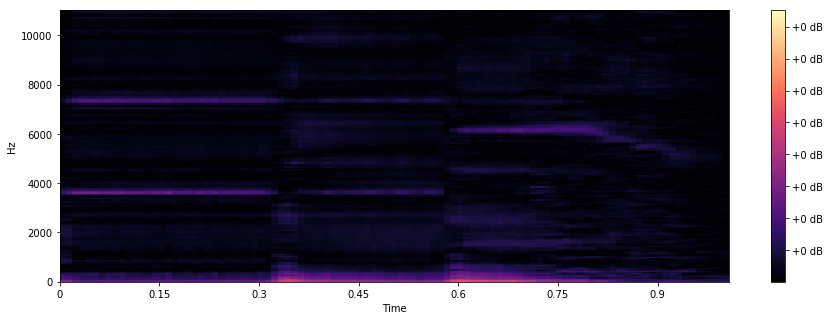

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
librosa.display.specshow(X_train[13], sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.show()

<font size = 4> <b> Final data preparation for all types of input

In [93]:
# Changing genres to encoded values

from sklearn.preprocessing import LabelEncoder

sle = LabelEncoder()
style_labels = sle.fit_transform(Y_train)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y_train = style_labels
style_mappings

{0: 'BN', 1: 'Funk', 2: 'Jazz', 3: 'Rock', 4: 'SS'}

In [94]:
style_labels = sle.fit_transform(Y_test)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y_test = style_labels
style_mappings

{0: 'BN', 1: 'Funk', 2: 'Jazz', 3: 'Rock', 4: 'SS'}

In [95]:
style_labels = sle.fit_transform(Y_validate)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y_validate = style_labels
style_mappings

{0: 'BN', 1: 'Funk', 2: 'Jazz', 3: 'Rock', 4: 'SS'}

In [96]:
print (Y_train)
print (Y_train.shape)
print (Y_test)
print (Y_test.shape)
print (Y_validate)
print (Y_validate.shape)

[0 0 0 ... 4 4 4]
(7140,)
[2 2 2 ... 4 4 4]
(1785,)
[1 1 1 ... 3 3 3]
(1785,)


<font size = 4> <b> Randomizing and saving raw datasets

In [97]:
random_state_path = 'CNN_NYU/random_states/'
Order_train = read_pkl(random_state_path + 'random_state_train_{}s_{}sets.pkl'.format(dur, num_sets))
Order_test = read_pkl(random_state_path + 'random_state_test_{}s_{}sets.pkl'.format(dur, num_sets))
Order_validate = read_pkl(random_state_path + 'random_state_validate_{}s_{}sets.pkl'.format(dur, num_sets))

In [98]:
print (Order_train)
print (Order_train.shape)
print (Order_test)
print (Order_test.shape)
print (Order_validate)
print (Order_validate.shape)

[4941. 1054.  316. ... 2646. 6599. 1457.]
(7140,)
[ 257.  263.  633. ...  681.  637. 1146.]
(1785,)
[1335.  653.  314. ...  373.  952. 1356.]
(1785,)


In [99]:
Y_train.shape

(7140,)

In [100]:
X_train_random = []
Y_train_random = np.array([])
print ('X_train shape', X_train[0, :, :].shape)
for i in Order_train:
    X_train_temp = X_train[int(i), :, :]
    Y_train_random = np.append(Y_train_random, Y_train[int(i)])
    X_train_random.append(X_train_temp)
X_train_random = np.array(X_train_random)
print ('X_train_random shape', X_train_random.shape)
print ('Y_train_random shape', Y_train_random.shape)

X_test_random = []
Y_test_random = np.array([])
print ('X_test shape', X_test[0, :, :].shape)
for i in Order_test:
    X_test_temp = X_test[int(i), :, :]
    Y_test_random = np.append(Y_test_random, Y_test[int(i)])
    X_test_random.append(X_test_temp)
X_test_random = np.array(X_test_random)
print ('X_test_random shape', X_test_random.shape)
print ('Y_test_random shape', Y_test_random.shape)

X_validate_random = []
Y_validate_random = np.array([])
print ('X_validate shape', X_validate[0, :, :].shape)
for i in Order_validate:
    X_validate_temp = X_validate[int(i), :, :]
    Y_validate_random = np.append(Y_validate_random, Y_validate[int(i)])
    X_validate_random.append(X_validate_temp)
X_validate_random = np.array(X_validate_random)
print ('X_validate_random shape', X_validate_random.shape)
print ('Y_validate_random shape', Y_validate_random.shape)

X_train shape (199, 101)
X_train_random shape (7140, 199, 101)
Y_train_random shape (7140,)
X_test shape (199, 101)
X_test_random shape (1785, 199, 101)
Y_test_random shape (1785,)
X_validate shape (199, 101)
X_validate_random shape (1785, 199, 101)
Y_validate_random shape (1785,)


In [101]:
Y_validate_random

array([4., 4., 3., ..., 1., 2., 4.])

In [102]:
output_path = 'CNN_NYU/Cepstrum/raw/{}/{}coeff/{}s_{}sets/'.format(n_fft, n_lift, dur, num_sets)
output_path

'CNN_NYU/Cepstrum/raw/1024/200coeff/1s_2sets/'

In [103]:
save_pkl(X_train_random, output_path + 'X_train_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(X_test_random, output_path + 'X_test_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(X_validate_random, output_path + 'X_validate_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(Y_train_random, output_path + 'Y_train_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(Y_test_random, output_path + 'Y_test_{}s_{}sets.pkl'.format(dur, num_sets))
save_pkl(Y_validate_random, output_path + 'Y_validate_{}s_{}sets.pkl'.format(dur, num_sets))

<font size = 4> <b> Saving the normalized data

In [104]:
# Reading raw data
path = 'CNN_NYU/Cepstrum/raw/{}/{}coeff/{}s_{}sets/'.format(n_fft, n_lift, dur, num_sets)

X_train = read_pkl(path + 'X_train_{}s_{}sets.pkl'.format(dur, num_sets))
X_test = read_pkl(path + 'X_test_{}s_{}sets.pkl'.format(dur, num_sets))
X_validate = read_pkl(path + 'X_validate_{}s_{}sets.pkl'.format(dur, num_sets))
Y_train = read_pkl(path + 'Y_train_{}s_{}sets.pkl'.format(dur, num_sets))
Y_test = read_pkl(path + 'Y_test_{}s_{}sets.pkl'.format(dur, num_sets))
Y_validate = read_pkl(path + 'Y_validate_{}s_{}sets.pkl'.format(dur, num_sets))

print (path)

CNN_NYU/Cepstrum/raw/1024/200coeff/1s_2sets/


In [105]:
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print (X_validate.shape)
print (Y_validate.shape)

(7140, 199, 101)
(7140,)
(1785, 199, 101)
(1785,)
(1785, 199, 101)
(1785,)


In [106]:
Y_validate

array([4., 4., 3., ..., 1., 2., 4.])

In [107]:
X_train_norm = norm(X_train)
X_test_norm = norm(X_test)
X_validate_norm = norm(X_validate)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719


5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367


6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014


1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737


1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785


In [108]:
output_path = 'CNN_NYU/Cepstrum/norm/{}/{}coeff/{}s_{}sets/'.format(n_fft, n_lift, dur, num_sets)
save_pkl(X_train_norm, output_path + 'X_train_norm_{}s_{}sets'.format(dur, num_sets))
save_pkl(X_test_norm, output_path + 'X_test_norm_{}s_{}sets'.format(dur, num_sets))
save_pkl(X_validate_norm, output_path + 'X_validate_norm_{}s_{}sets'.format(dur, num_sets))